# In this notebook, we shall train LSTM models for tweet level classification

We shall aim to train 2 types of models, one LSTM that purely makes use of textual data and another LSTM that uses the metadata that comes with the tweet level data

In [22]:
#import necessary libraries
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D, BatchNormalization, Bidirectional, Input, Concatenate, concatenate, Masking
from tensorflow.keras.utils import plot_model

from transformers import BertTokenizer, BertModel, pipeline
import gensim
from gensim import downloader
import pickle

from xgboost import XGBClassifier

In [4]:
#Reading in the data
tweets = pd.read_csv('tweets_dataset_allcols.csv')

In [5]:
tweets.head()

,id,text,source,user_id,retweeted_status_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,bot,cleaned_text,isBot
0,558857025270988801,aleah is me http://t.co/PXwTMPzLFf,"<a href=""http://twitter.com/download/iphone"" r...",2.286244e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sat Jan 24 05:21:12 +0000 2015,0,aleah is me,0
1,361688175418150913,@WittyOfficial I got you bruh,"<a href=""http://twitter.com/download/iphone"" r...",2.575995e+07,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Mon Jul 29 03:22:35 +0000 2013,0,__user_mention__ I got you bruh,0
2,109649117361344513,@MissKotzyba its a diet where u can only eat p...,"<a href=""http://blackberry.com/twitter"" rel=""n...",1.093557e+07,NaN,0.0,0.0,0.0,0.0,1.0,1.0,Fri Sep 02 15:29:21 +0000 2011,1,__user_mention__ its a diet where u can only e...,1
3,252533532839260161,When we are no longer able to change a situati...,web,6.176962e+08,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Sun Sep 30 22:21:00 +0000 2012,1,When we are no longer able to change a situati...,1
4,576292622286749696,@cat_lover_996 @Lauri777Ellonen @Wendy_Rich_UK...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",2.223970e+09,0.0,0.0,0.0,0.0,0.0,0.0,4.0,Fri Mar 13 08:04:02 +0000 2015,0,__user_mention__ __user_mention__ __user_menti...,0


In [6]:
#As we can see, the tweets are already 
tweets.bot.value_counts()

0    25000
1    25000
Name: bot, dtype: int64

# Metadata only model
In this section, we shall use only the meta data associated with each individual tweet (as opposed to account level data, which is handled in our other section) in order to see if patterns in the metadata is sufficient to distinguish bot generated tweets from human generated tweets. The features that we are going to use is retweet_count	reply_count	favorite_count	num_hashtags	num_urls	num_mentions.

In [6]:
X = tweets[["retweet_count","reply_count", "favorite_count", "num_hashtags", "num_urls", "num_mentions"]]
y = tweets[['bot']]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y)

In [15]:
#The classes are already balanced, so we
log_reg = LogisticRegression()

log_reg.fit(X_train, y_train.bot)

LogisticRegression()

In [16]:
y_pred = log_reg.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.62      0.67      5000
           1       0.67      0.77      0.72      5000

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.69     10000
weighted avg       0.70      0.69      0.69     10000



In [19]:
#Checking for overfitting
y_train_pred = log_reg.predict(X_train)
print(classification_report(y_train, y_train_pred))
#As can be seen below, training set and test set performance are similar, indicating that there is no overfitting

              precision    recall  f1-score   support

           0       0.72      0.60      0.66     20000
           1       0.66      0.77      0.71     20000

    accuracy                           0.68     40000
   macro avg       0.69      0.68      0.68     40000
weighted avg       0.69      0.68      0.68     40000



As we can see from the classification report above, the logistic regression model is able to perform much better than random acheiving precision, recall and f1 scores of around 0.7. 

This shows that tweet level meta features do have predictive power in determining whether a tweet is generated by a bot or a human.

# Vanilla LSTM
In this section, the LSTM model that we create simply uses a standard LSTM architecture and only takes into account the textual data in a tweet to determine whether it is generated by a human or a bot. First, we try using a self trained w2v, then a pretrained glove

In [128]:
#here, we shall use a self trained word 2 vec and train an LSTM model
X = tweets[['cleaned_text']]
y = tweets[['bot']]

#Before training word to vec, we shall split into train test split to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [129]:
X_train_sentence = [d.split() for d in X_train['cleaned_text'].tolist()]

In [130]:
#we shall try training a 50d w2v model first
#create the word to vector
#try a 50 dimensional vector first
dim = 50
#Fit a Word2Vec model on our dataset
w2v = gensim.models.Word2Vec(sentences = X_train_sentence, vector_size = dim, window = 10, min_count = 1)

In [131]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_sentence)

In [132]:
#tokenize the words (this is for padding later), basically converts the sentences into lists of numbers in which
#will be used in the embedding layer of the LSTM
X_train_tokens = tokenizer.texts_to_sequences(X_train_sentence)

In [133]:
max_length = max([len(x) for x in X_train_tokens])

In [134]:
#Next, we can pad the sequences, because the Neural net takes in constant length vectors
X_train_tokens = pad_sequences(X_train_tokens, maxlen = max_length)

In [137]:
#this is for determining the embedding matrix to be used in the LSTM
vocab = tokenizer.word_index
vocabulary_size = len(tokenizer.word_index) + 1

In [138]:
#create the embedding matrix according to our word embeddings, this matrix is to store all the word embeddings according to
#our training above (each word gets its own vector)
embedding_mat = np.zeros((vocabulary_size, dim))
num_words = 0
#insert the word embeddings into our initialised object
for word, token in tokenizer.word_index.items():

    #get the corresponding vector to the word and the token
    #if the word is present in the dictionary, then we append the corresponding matrix else we continue
    if word in w2v.wv:
        #access the vector embedding that was generated by our word2vec model
        vector = w2v.wv[word]
        embedding_mat[token] = vector
        num_words += 1

In [23]:
#Creating the LSTM model

inputs = Input(shape = (max_length,))
#we do not want our embedding layer to be traininable
embedding = Embedding(input_dim = vocabulary_size, output_dim = dim, input_length = max_length, weights = [embedding_mat],
                     trainable = False)(inputs)
#next, we add the lstm layer 
lstm = LSTM(units = 32, recurrent_dropout = 0.3)(embedding)
#finally, add 2 dense layers
dense1 = Dense(units = 128, activation = 'relu')(lstm)
dense2 = Dense(units = 64, activation = 'relu') (dense1)
#The final cell is the output cell with a softmax 
output = Dense(units = 1, activation = 'sigmoid')(dense2)

model = Model(inputs = inputs, outputs = output)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])


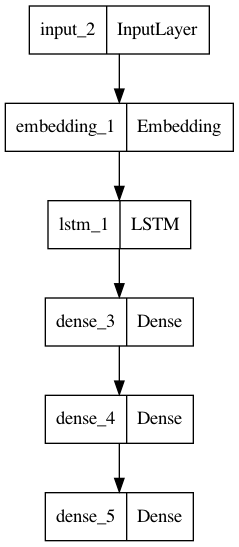

In [24]:
plot_model(model)

In [141]:
model.fit(X_train_tokens, y_train, epochs = 8)

Epoch 1/8
1250/1250 [==============================] - 19s 13ms/step - loss: 0.6000 - acc: 0.6795
Epoch 2/8
1250/1250 [==============================] - 17s 13ms/step - loss: 0.5698 - acc: 0.7074
Epoch 3/8
1250/1250 [==============================] - 17s 14ms/step - loss: 0.5593 - acc: 0.7139
Epoch 4/8
1250/1250 [==============================] - 17s 13ms/step - loss: 0.5537 - acc: 0.7161
Epoch 5/8
1250/1250 [==============================] - 19s 15ms/step - loss: 0.5484 - acc: 0.7202
Epoch 6/8
1250/1250 [==============================] - 19s 15ms/step - loss: 0.5423 - acc: 0.7231
Epoch 7/8
1250/1250 [==============================] - 17s 14ms/step - loss: 0.5385 - acc: 0.7254
Epoch 8/8
1250/1250 [==============================] - 17s 13ms/step - loss: 0.5352 - acc: 0.7271


In [143]:
#getting tokenizations for test data 
X_test_sentence = [d.split() for d in X_test['cleaned_text'].tolist()]
X_test_tokens = tokenizer.texts_to_sequences(X_test_sentence)

In [144]:
X_test_tokens = pad_sequences(X_test_tokens, maxlen = max_length)

In [145]:
y_pred_proba = model.predict(X_test_tokens)

313/313 [==============================] - 2s 4ms/step


In [146]:
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

In [147]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.68      0.71      5000
           1       0.71      0.78      0.74      5000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



In [ ]:
print(roc_auc_score(y_test, y_pred))

In [ ]:
#We are able to obtain 0.73 accuracy by using our own pretrained word2vec model. However, the data we have to train this vector 
#representation is rather small at only 50000

# LSTM with pretrained glove.
Here, we use the pretrained glove by stanford glove (https://nlp.stanford.edu/projects/glove/). Here, the authors have trained their vector representations on billions of tweets and it is likely that they are able to obtain superior text representations as compared to our self trained word to vec model.

In [97]:
#First, the glove cannot handle punctuated words and does not contain punctuation, so we shall find and replace all such occurences
short_form_dict = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
    "that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",}

def replace_short_form(text):
    for key, value in short_form_dict.items():
        text = text.replace(key, value)
    return text

In [7]:
glove_100 = downloader.load('glove-twitter-100')

In [98]:
#preprocessing steps for glove (taken from and adjusted https://www.kaggle.com/code/amackcrane/python-version-of-glove-twitter-preprocess-script)
import sys
import regex as re

FLAGS = re.MULTILINE | re.DOTALL

def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = "<hashtag> {} <allcaps>".format(hashtag_body.lower())
    else:
        result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return result

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps> " # amackcrane added trailing space


def preprocess_glove(text):
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)
    
    text = text.lower()
    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"<3","<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"#\w+", hashtag)  # amackcrane edit
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")
    



    text = re_sub(r"([a-zA-Z<>()])([?!.:;,])", r"\1 \2")
    text = re_sub(r"\(([a-zA-Z<>]+)\)", r"( \1 )")
    text = re_sub(r"  ", r" ")
    text = re_sub(r" ([A-Z]){2,} ", allcaps)
    text = replace_short_form(text)
    punct =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '.',
           '/', ':', ';', '=', '?', '@', '[', '\\', ']', '^', '_', 
           '`', '{', '|', '}', '~', '»', '«', '“', '”', '—', ]
    punct_pattern = re.compile("[" + re.escape("".join(punct)) + "]")
    text = re.sub(punct_pattern, "", text)
    text = text.replace("…", "")
    text = text.replace("<number>th", "<number>")
    text = text.replace("><", "> <")
    pattern = re.compile(r'A1.8301$')
    text = text.replace("♥", "<heart>")
    
    return text



In [99]:
tweets['glove_preprocessed'] = tweets.text.apply(preprocess_glove)

In [162]:
#here, we shall use a self trained word 2 vec and train an LSTM model (include the metadata features here for the next section
#where the LSTM makes use of both metadata features and text features)
X = tweets[["retweet_count","reply_count", "favorite_count", "num_hashtags", "num_urls", "num_mentions",'glove_preprocessed']]
y = tweets[['bot']]

#Before training word to vec, we shall split into train test split to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [163]:
X_train_sentence = [d.split() for d in X_train['glove_preprocessed'].tolist()]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_sentence)

In [164]:
#tokenize the words (this is for padding later), basically converts the sentences into lists of numbers in which
#will be used in the embedding layer of the LSTM
X_train_tokens = tokenizer.texts_to_sequences(X_train_sentence)

In [165]:
max_length = max([len(x) for x in X_train_tokens])


In [166]:
vocabulary_size = len(tokenizer.word_index) + 1

In [167]:
X_train_tokens = pad_sequences(X_train_tokens, maxlen = max_length)

In [168]:
dim = 100
embedding_mat_glove = np.zeros((vocabulary_size, dim))
num_words = 0
not_in_vocab = 0
#insert the word embeddings into our initialised object
for word, token in tokenizer.word_index.items():
    
    #first, we remove any punctuation from the words and store a modified version of the word
    #word_modified = ''.join(c for c in word if c.isalnum() or c == '<' or c == '>')
    #get the corresponding vector to the word and the token
    #if the word is present in the dictionary, then we append the corresponding matrix else we continue
    if word in glove_100:
        vector = glove_100[word]
        embedding_mat_glove[token] = vector
        num_words +=1
    else:
        not_in_vocab += 1

In [169]:
#Creating the LSTM model

inputs = Input(shape = (max_length,))
#we do not want our embedding layer to be traininable
embedding = Embedding(input_dim = vocabulary_size, output_dim = dim, input_length = max_length, weights = [embedding_mat_glove],
                     trainable = False)(inputs)
#next, we add the lstm layer 
lstm = LSTM(units = 32, recurrent_dropout = 0.3)(embedding)
#finally, add 2 dense layers
dense1 = Dense(units = 128, activation = 'relu')(lstm)
dense2 = Dense(units = 64, activation = 'relu') (dense1)
#The final cell is the output cell with a softmax 
output = Dense(units = 1, activation = 'sigmoid')(dense2)

model = Model(inputs = inputs, outputs = output)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [170]:
model.fit(X_train_tokens, y_train.bot, epochs = 8)

Epoch 1/8
1250/1250 [==============================] - 21s 14ms/step - loss: 0.5547 - acc: 0.7123
Epoch 2/8
1250/1250 [==============================] - 18s 15ms/step - loss: 0.4946 - acc: 0.7594
Epoch 3/8
1250/1250 [==============================] - 18s 15ms/step - loss: 0.4656 - acc: 0.7786
Epoch 4/8
1250/1250 [==============================] - 18s 14ms/step - loss: 0.4445 - acc: 0.7930
Epoch 5/8
1250/1250 [==============================] - 24s 19ms/step - loss: 0.4255 - acc: 0.8023
Epoch 6/8
1250/1250 [==============================] - 26s 21ms/step - loss: 0.4065 - acc: 0.8149
Epoch 7/8
1250/1250 [==============================] - 25s 20ms/step - loss: 0.3905 - acc: 0.8217
Epoch 8/8
1250/1250 [==============================] - 19s 16ms/step - loss: 0.3746 - acc: 0.8290


In [171]:
#Generate Xtest tokens to see performance on test set

X_test_sentence = [d.split() for d in X_test['glove_preprocessed'].tolist()]
X_test_tokens = tokenizer.texts_to_sequences(X_test_sentence)

In [172]:
X_test_tokens = pad_sequences(X_test_tokens, maxlen = max_length)

In [173]:
y_pred_proba = model.predict(X_test_tokens)

313/313 [==============================] - 2s 4ms/step


In [174]:
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

In [175]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.72      0.75      5000
           1       0.74      0.81      0.77      5000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.77      0.76      0.76     10000



In [ ]:
print(roc_auc_score(y_test, y_pred))

# Metadata + text LSTM
From previous sections, we can see that both the textual content of the tweets and the metadata of the tweets have predictive power in classifying whether a tweet is generated from a bot or a human. Now, we shall construct an LSTM that makes use of both the textual content of a tweet and the metadata of a tweet and attempt to classify whether it was generated by a bot or a human.

For this part, we shall continue to use the pretrained glove text representations since performance was superior as compared to self trained word 2 vec.


In [176]:
#Getting and scaling the metadata features

sc = StandardScaler()
metadata = X_train[["retweet_count","reply_count", "favorite_count", "num_hashtags", "num_urls", "num_mentions"]]

#Fit the standard scaler on training data only to avoid data leakage
metadata_scaled = sc.fit_transform(metadata)

In [178]:
#Defining the nn architecture:

#here, we have multiple inputs (max len because each input is a list of tokens)
input_tweet = Input(shape = (max_length,))
#The list of tokens is passed to an embedding layer, where the pretrained glove embeddings for each word are stored accessed
#by the respective tokens before being passed into the LSTM layer
embedding = Embedding(input_dim = vocabulary_size, output_dim = dim, input_length = max_length, weights = [embedding_mat_glove],
                     trainable = False)(input_tweet)
lstm = LSTM(units = 32)(embedding)

#for the 6 features that we have
input_metadata = Input(shape = (6,))
combined = concatenate([input_metadata, lstm])
#Then pass the combined input to a dense layer
dense1 = Dense(128, activation = 'relu')(combined)
dense2 = Dense(64, activation = 'relu')(dense1)
output = Dense(1, activation = 'sigmoid')(dense2)

model = Model(inputs = [input_tweet, input_metadata], outputs = [output])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [186]:
model.fit(x = [X_train_tokens, metadata_scaled], y = y_train.bot, epochs = 12)

Epoch 1/12
1250/1250 [==============================] - 15s 11ms/step - loss: 0.4294 - acc: 0.8040
Epoch 2/12
1250/1250 [==============================] - 15s 12ms/step - loss: 0.3932 - acc: 0.8214
Epoch 3/12
1250/1250 [==============================] - 15s 12ms/step - loss: 0.3677 - acc: 0.8357
Epoch 4/12
1250/1250 [==============================] - 15s 12ms/step - loss: 0.3464 - acc: 0.8467
Epoch 5/12
1250/1250 [==============================] - 15s 12ms/step - loss: 0.3265 - acc: 0.8564
Epoch 6/12
1250/1250 [==============================] - 15s 12ms/step - loss: 0.3067 - acc: 0.8667
Epoch 7/12
1250/1250 [==============================] - 15s 12ms/step - loss: 0.2914 - acc: 0.8735
Epoch 8/12
1250/1250 [==============================] - 15s 12ms/step - loss: 0.2770 - acc: 0.8817
Epoch 9/12
1250/1250 [==============================] - 14s 11ms/step - loss: 0.2611 - acc: 0.8895
Epoch 10/12
1250/1250 [==============================] - 14s 11ms/step - loss: 0.2462 - acc: 0.8963
Epoch 11/

In [187]:
#preprocess the test set metadata
metadata_test = X_test[["retweet_count","reply_count", "favorite_count", "num_hashtags", "num_urls", "num_mentions"]]

meta_test_scaled = sc.transform(metadata_test)

In [188]:
y_pred_proba = model.predict([X_test_tokens, meta_test_scaled])

313/313 [==============================] - 2s 6ms/step


In [189]:
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

In [190]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      5000
           1       0.80      0.76      0.78      5000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



In [ ]:
print(roc_auc_score(y_test, y_pred))

### As we can see from the classification report above, the combined LSTM performs slightly better than the pure textual data model and significantly better than the logistic regression model that uses only metadata.


# Bert embeddings
In this section, we shall try fitting LSTM models on bert embeddings. Previously we used Glove and Word2Vec which are non contextual word embeddings. In other words, we just get one numeric representation of all same words, ie the word bank always has one vector representation despite the possibility that the word bank is used in different contexts. However, BERT can capture different embeddings for each word depending on the context that it is used. Hence, we shall now train an LSTM using BERT embeddings.


In [7]:
#here, we shall use a self trained word 2 vec and train an LSTM model (include the metadata features here for the next section
#where the LSTM makes use of both metadata features and text features)
X = tweets[["retweet_count","reply_count", "favorite_count", "num_hashtags", "num_urls", "num_mentions",'cleaned_text']]
y = tweets[['bot']]

#Before training word to vec, we shall split into train test split to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [16]:
#Here, we shall initialize a pretrained bert model (smaller dimensions than the other one)
tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny", padding = True)
model = BertModel.from_pretrained("prajjwal1/bert-tiny")
nlp = pipeline("feature-extraction", tokenizer = tokenizer, model = model)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

C:\Users\veena\anaconda3\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\veena\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/285 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
#Getting the bert embeddings

#store all the tweets after they have been encoded by BERT

feature_list = []

max_dim = 0
for index, row in X_train.iterrows():
    #extracting the ith tweet and restricting the characters to 512, which is fine because twitter's limit is 280
    text = row['cleaned_text'][:512]
    #encoding all the individual words present in the tweet
    vec = np.array(nlp(text))

    shp = vec.shape[1]
    vec = np.pad(vec, ((0,0),(0,120 - shp),(0,0)), mode = 'constant', constant_values = -10)
#   #getting the mean representation of the words present in the tweet

    feature_list.append(vec)
    

feature_vectors_train = np.array(feature_list)

In [42]:
feature_list_test = []

max_dim = 0
for index, row in X_test.iterrows():
    #extracting the ith tweet and restricting the characters to 512, which is fine because twitter's limit is 280
    text = row['cleaned_text'][:512]
    #encoding all the individual words present in the tweet
    vec = np.array(nlp(text))

    shp = vec.shape[1]
    vec = np.pad(vec, ((0,0),(0,120 - shp),(0,0)), mode = 'constant', constant_values = -10)
#   #getting the mean representation of the words present in the tweet

    feature_list_test.append(vec)
    

feature_vectors_test = np.array(feature_list_test)

In [43]:
feature_vectors_test = feature_vectors_test.reshape((10000, 120, 128))

In [44]:
feature_vectors_train = feature_vectors_train.reshape(40000, 120, 128)

In [45]:
feature_vectors_train.shape

(40000, 120, 128)

In [46]:
#Creating the model for bert embedding

input_tweet = Input(shape = (120, 128))
mask = Masking(mask_value=-10)(input_tweet)
lstm = LSTM(32)(mask)
dense1 = Dense(units = 128, activation = 'relu')(lstm)
dense2 = Dense(units = 64, activation = 'relu') (dense1)
#The final cell is the output cell with a softmax 
output = Dense(units = 1, activation = 'sigmoid')(dense2)

model = Model(inputs = input_tweet, outputs = output)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])


In [47]:
model.fit(x = feature_vectors_train, y = y_train.bot, epochs = 15)

Epoch 1/15
1250/1250 [==============================] - 83s 60ms/step - loss: 0.5836 - acc: 0.6873
Epoch 2/15
1250/1250 [==============================] - 70s 56ms/step - loss: 0.5254 - acc: 0.7327
Epoch 3/15
1250/1250 [==============================] - 70s 56ms/step - loss: 0.5042 - acc: 0.7478
Epoch 4/15
1250/1250 [==============================] - 71s 56ms/step - loss: 0.4866 - acc: 0.7598
Epoch 5/15
1250/1250 [==============================] - 62s 50ms/step - loss: 0.4720 - acc: 0.7710
Epoch 6/15
1250/1250 [==============================] - 66s 53ms/step - loss: 0.4579 - acc: 0.7801
Epoch 7/15
1250/1250 [==============================] - 63s 51ms/step - loss: 0.4447 - acc: 0.7890
Epoch 8/15
1250/1250 [==============================] - 68s 55ms/step - loss: 0.4302 - acc: 0.7993
Epoch 9/15
1250/1250 [==============================] - 63s 50ms/step - loss: 0.4185 - acc: 0.8070
Epoch 10/15
1250/1250 [==============================] - 67s 53ms/step - loss: 0.4069 - acc: 0.8138
Epoch 11/

In [48]:
y_pred_prob = model.predict(feature_vectors_test)

313/313 [==============================] - 10s 23ms/step


In [49]:
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76      5000
           1       0.77      0.73      0.75      5000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



In [51]:
print(roc_auc_score(y_test, y_pred))

0.7570000000000001


In [55]:
#Now training a combined model
meta_data_train = X_train.drop('cleaned_text', axis = 1)

In [57]:
sc = StandardScaler()

In [58]:
meta_data_train[['retweet_count', 'reply_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions']] = sc.fit_transform(meta_data_train[['retweet_count', 'reply_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions']])

In [59]:
meta_data_test = X_test.drop('cleaned_text', axis = 1)
meta_data_test[['retweet_count', 'reply_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions']] = sc.transform(meta_data_test[['retweet_count', 'reply_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions']])

In [61]:
#Multichannel Neural Network with bert input

#Creating the model for bert embedding

input_tweet = Input(shape = (120, 128))
mask = Masking(mask_value=-10)(input_tweet)
lstm = LSTM(32)(mask)
input_metadata = Input(shape = (6,))
combined = concatenate([input_metadata, lstm])
dense1 = Dense(units = 128, activation = 'relu')(combined)
dense2 = Dense(units = 64, activation = 'relu') (dense1)
#The final cell is the output cell with a softmax 
output = Dense(units = 1, activation = 'sigmoid')(dense2)

model = Model(inputs = [input_tweet, input_metadata], outputs = output)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])


In [62]:
model.fit(x = [feature_vectors_train, meta_data_train], y = y_train, epochs = 15)

Epoch 1/15
1250/1250 [==============================] - 82s 60ms/step - loss: 0.5303 - acc: 0.7289
Epoch 2/15
1250/1250 [==============================] - 73s 59ms/step - loss: 0.4725 - acc: 0.7695
Epoch 3/15
1250/1250 [==============================] - 88s 70ms/step - loss: 0.4466 - acc: 0.7849
Epoch 4/15
1250/1250 [==============================] - 86s 69ms/step - loss: 0.4264 - acc: 0.7980
Epoch 5/15
1250/1250 [==============================] - 82s 66ms/step - loss: 0.4087 - acc: 0.8075
Epoch 6/15
1250/1250 [==============================] - 84s 67ms/step - loss: 0.3930 - acc: 0.8182
Epoch 7/15
1250/1250 [==============================] - 86s 69ms/step - loss: 0.3771 - acc: 0.8265
Epoch 8/15
1250/1250 [==============================] - 79s 63ms/step - loss: 0.3639 - acc: 0.8350
Epoch 9/15
1250/1250 [==============================] - 77s 62ms/step - loss: 0.3505 - acc: 0.8424
Epoch 10/15
1250/1250 [==============================] - 79s 64ms/step - loss: 0.3378 - acc: 0.8471
Epoch 11/

In [63]:
y_pred_prob = model.predict([feature_vectors_test, meta_data_test])

313/313 [==============================] - 11s 23ms/step


In [64]:
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      5094
           1       0.80      0.81      0.81      4906

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [66]:
print(roc_auc_score_score(y_test, y_pred))

0.8072


# Training a model purely on metadata for comparison

Here, we shall train a xgboost model purely on the tweet data in order to compare with the results of the multichannel network.

In [82]:
xgb_metadata = XGBClassifier(gamma = 0.1,
                               alpha = 0.5,
                               max_depth = 25, 
                               eta = 0.01, 
                               subsample = 0.8,
                               colsample_bytree = 1.0,
                               
                               objective = "binary:logistic",
                               eval_metric = "logloss")

In [83]:
xgb_metadata.fit(meta_data_train, y_train)

XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False, eta=0.01,
              eval_metric='logloss', feature_types=None, gamma=0.1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.00999999978,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=25, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, ...)

In [84]:
y_pred = xgb_metadata.predict(meta_data_test)

In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.70      0.77      5000
           1       0.75      0.88      0.81      5000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



While the results are better than the pure text LSTM models, the multichannel network outperforms this model, in particular for the human class, where the f1-score is significantly higher.